# Trabalho Prático II - Transfer Learning 

# Fernanda Guimarães - 2016058166

In [ ]:
import matplotlib as mpl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython.display import display
from IPython.display import Markdown

import keras
from keras import datasets
from keras import optimizers
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras import backend as K

# Tira os warnings do TF
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

def printmd(s):
    display(Markdown(s))

Using TensorFlow backend.


In [ ]:
# Carrega as imagens ja separadas entre treino e teste. Na primeira vez eh necessario fazer o download
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()


170500096/170498071 [==============================] - 20s 0us/step


## Olhando para os Dados

A primeira coisa que fazemos quando nos aproximamos de um problema é dar uma olhada nos dados. Nós sempre precisamos entender muito bem qual é o problema e como os dados se parecem antes de podermos descobrir como resolvê-lo. Dar uma olhada nos dados significa entender quais são as etiquetas e como algumas imagens de amostra se parecem.

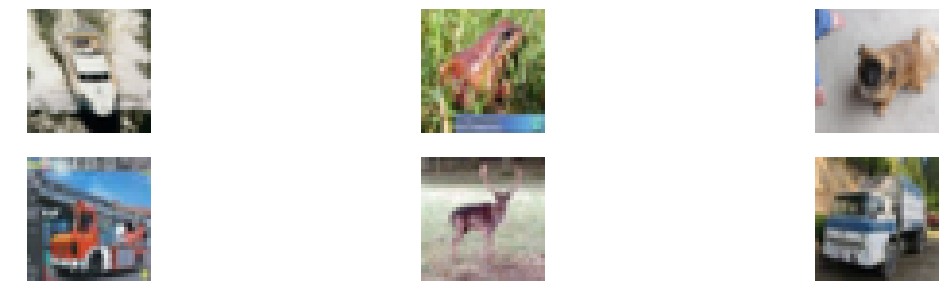

In [ ]:
n_rows = 2
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))

for i in range(n_rows):
    for j in range(n_cols):
        img_i = np.random.randint(0, x_train.shape[0])
        axes[i][j].imshow(x_train[img_i], cmap="gray")
        axes[i][j].axis("off")
plt.show()

Aqui vemos que há nove (9) classes.

In [ ]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Separação dos Dados



```
# This is formatted as code
```

### Dataset B: índices 1 e 6 (últimos dígitos da matrícula)

In [ ]:
indexesB = list(filter(lambda x:x[1] in (1,6), enumerate(y_train)))
indexesB_2 = list(filter(lambda x:x[1] in (1,6), enumerate(y_test)))

In [ ]:
indexesB = [idx[0] for idx in indexesB]
indexesB = np.array(indexesB)

In [ ]:
indexesB_2 = [idx[0] for idx in indexesB_2]
indexesB_2 = np.array(indexesB_2)

In [ ]:
trainB_1 = x_train[indexesB]
trainB_2 = x_test[indexesB_2]
x_trainB = np.concatenate((trainB_1, trainB_2), axis=0)

In [ ]:
y_trainB_1 = np.array(list(filter(lambda x:x in (1,6), y_train)))
y_trainB_2 = np.array(list(filter(lambda x:x in (1,6), y_test)))
y_trainB = np.concatenate((y_trainB_1, y_trainB_2), axis=0)

In [ ]:
x_trainB.shape

(12000, 32, 32, 3)

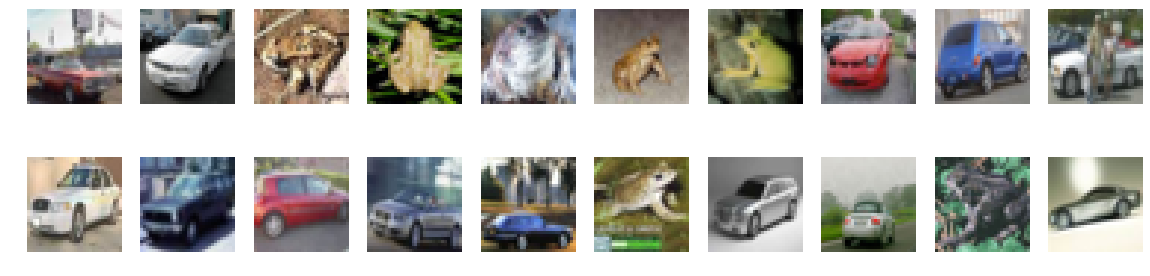

In [ ]:
n_rows = 2
n_cols = 10

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))

for i in range(n_rows):
    for j in range(n_cols):
        img_i = np.random.randint(0, x_trainB.shape[0])
        axes[i][j].imshow(x_trainB[img_i], cmap="gray")
        axes[i][j].axis("off")
plt.show()


Aqui, vemos que há apenas 2 classes restantes, como esperado: carros e sapos.

### Restante do Dataset (parte A)

In [ ]:
indexesA = list(filter(lambda x:x[1] not in (1,6), enumerate(y_train)))
indexesA_2 = list(filter(lambda x:x[1] not in (1,6), enumerate(y_test)))

In [ ]:
indexesA = [idx[0] for idx in indexesA]
indexesA = np.array(indexesA)

In [ ]:
indexesA_2 = [idx[0] for idx in indexesA_2]
indexesA_2 = np.array(indexesA_2)

In [ ]:
trainA_1 = x_train[indexesA]
trainA_2 = x_test[indexesA_2]
x_trainA = np.concatenate((trainA_1, trainA_2), axis=0)
x_trainA.shape

(48000, 32, 32, 3)

In [ ]:
y_trainA_1 = np.array(list(filter(lambda x:x not in (1,6), y_train)))
y_trainA_2 = np.array(list(filter(lambda x:x not in (1,6), y_test)))
# y_trainA = np.vstack((y_trainA_1, y_trainA_2)); y_trainA
y_trainA = np.concatenate((y_trainA_1, y_trainA_2), axis=0)
y_trainA.shape

(48000, 1)

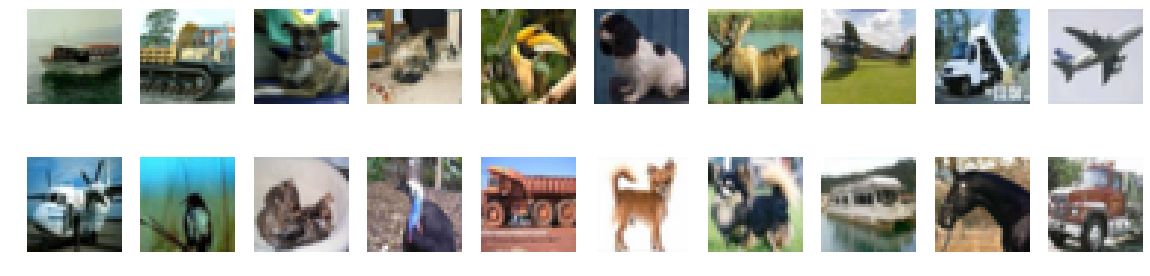

In [ ]:
n_rows = 2
n_cols = 10

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))

for i in range(n_rows):
    for j in range(n_cols):
        img_i = np.random.randint(0, x_trainA.shape[0])
        axes[i][j].imshow(x_trainA[img_i], cmap="gray")
        axes[i][j].axis("off")
plt.show()


Aqui, vemos que no Dataset B há apenas sapos e carros, enquanto o restante ficou no Dataset A.

## Normalização dos dados

In [ ]:
# refaz a forma do target de forma que fique unidimensional
y_trainA = np.reshape(y_trainA, len(y_trainA))
y_trainB = np.reshape(y_trainB, len(y_trainB))

In [ ]:
# Normaliza a intensidade dos pixels para o intervalo [0, 1]
x_trainA = x_trainA/255
x_trainB = x_trainB/255

# # One-hot encoding dos targets
y_trainA = pd.get_dummies(y_trainA).values
y_trainB = pd.get_dummies(y_trainB).values


# Pega o número de classes
n_classesA = y_trainA.shape[1]
n_classesB = y_trainB.shape[1]

In [ ]:
n_classesA

8

In [ ]:
n_classesB

2

### Split o dataset A em treino and teste

In [ ]:
# 0.8 para treino e 0.2 para teste
x_train_A  = x_trainA[:int(len(x_trainA)* 0.8)]
y_train_A  = y_trainA[:int(len(y_trainA)* 0.8)]
print(len(x_train_A), len(y_train_A))

38400 38400


In [ ]:
x_test_A  = x_trainA[int(len(x_trainA)* 0.8):]
y_test_A  = y_trainA[int(len(y_trainA)* 0.8):]
print(len(x_test_A), len(y_test_A))

9600 9600


In [ ]:
x_train_A.shape

(38400, 32, 32, 3)

In [ ]:
y_train_A.shape

(38400, 8)

### Split o dataset B em treino e teste

In [ ]:
# 0.8 para treino e 0.2 para teste
x_train_B  = x_trainB[:int(len(x_trainB)* 0.8)]
y_train_B  = y_trainB[:int(len(y_trainB)* 0.8)]
print(len(x_train_B), len(y_train_B))

9600 9600


In [ ]:
x_test_B  = x_trainB[int(len(x_trainB)* 0.8):]
y_test_B  = y_trainB[int(len(y_trainB)* 0.8):]
print(len(x_test_B), len(y_test_B))

2400 2400


In [ ]:
x_train_B.shape

(9600, 32, 32, 3)

In [ ]:
y_train_B.shape

(9600, 2)

### Treino A

Aqui, é construída uma convnet com as seguintes camadas:
  - Conv2d
  - Relu
  - BatchNormalization
  - Conv2d
  - Relu
  - BatchNormalization
  - MaxPooling
  - Dropout
  - Conv2d
  - Relu
  - BatchNormalization
  - Conv2d
  - Relu
  - BatchNormalization
  - MaxPooling
  - Dropout
  - Flatten
  - Dense
  - Dense


  
  
  
  

#### Batch Normalization

Reduz overfitting porque tem um leve efeito de suavização. Semelhante ao dropout, adiciona algum ruído às ativações de cada camada oculta. Portanto, se usarmos a normalização em batch, usaremos menos droput, o que é bom porque não perderemos muita informação. No entanto, não devemos confiar apenas na normalização em batches para regularização; devemos usá-lo melhor com o dropout.

Para aumentar a estabilidade de uma rede neural, a normalização em batch normaliza a saída de uma camada de ativação anterior, subtraindo a média do batch e dividindo pelo desvio padrão do batch.

#### Mixup

O paper mixup: BEYOND EMPIRICAL RISK MINIMIZATION oferece uma alternativa à técnica tradicional de data augmentation como dar zoom e fazer rotações. Formando um novo exemplo através da interpolação linear dos pesos de dois exemplos de treino. Há um fator de multiplicação advindo da distribuição beta. O código do mixup foi retirado do paper, e está disponível em: https://github.com/yu4u/mixup-generator

In [ ]:
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.1, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [ ]:
weight_decay = 1e-4
strides = 1
batch_size = 200

model = Sequential()
layer = Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train_A.shape[1:], strides=strides, kernel_initializer='he_normal')
model.add(layer)
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), strides=strides, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),strides=strides, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), strides=strides, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(n_classesA, activation='softmax'))
 
model.summary()
 
#data augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train_A)
training_generator = MixupGenerator(x_train_A, y_train_A, batch_size=batch_size, alpha=0.2, datagen=datagen)()
#training

epochs = 20

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)

#opt_rms = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model.fit_generator(training_generator,\
                    steps_per_epoch=x_train_A.shape[0] // batch_size,epochs=20,\
                    verbose=1)
 
#testing
scores = model.evaluate(x_test_A, y_test_A, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))
#indexes = list(filter(lambda x:x[1] == 1, enumerate(y_train)))
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

In [ ]:
model_A = model

In [ ]:
model_A.save_weights('model_A.h5')

### Treino B - sem transfer learning

In [ ]:
weight_decay = 1e-4
strides = 1
model = Sequential()
layer = Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train_B.shape[1:], strides=strides, kernel_initializer='he_normal')
model.add(layer)
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), strides=strides, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),strides=strides, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), strides=strides, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(n_classesB, activation='softmax'))
 
model.summary()

#data augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train_B)
training_generator = MixupGenerator(x_train_B, y_train_B, batch_size=batch_size, alpha=0.2, datagen=datagen)()
#training
batch_size = 200
epochs = 20

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)

#opt_rms = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model.fit_generator(training_generator,\
                    steps_per_epoch=x_train_B.shape[0] // batch_size,epochs=20,\
                    verbose=1)
 
#testing
scores = model.evaluate(x_test_B, y_test_B, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))
#indexes = list(filter(lambda x:x[1] == 1, enumerate(y_train)))
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_25 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_26 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 64)        0         
__________

### Treino B - Transfer Learning 1

In [ ]:
weight_decay = 1e-4
strides = 1
model = Sequential()

print(modelB.output_shape)
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train_B.shape[1:], strides=strides, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), strides=strides, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),strides=strides, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), strides=strides, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(n_classesB, activation='softmax'))

 
model.summary()

#data augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train_B)
training_generator = MixupGenerator(x_train_B, y_train_B, batch_size=batch_size, alpha=0.2, datagen=datagen)()
#training
batch_size = 200
epochs = 20

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

model.load_weights('model_A.h5', by_name=True) # loads the weights from pre-trained network
model.layers[-1].trainable = False
model.fit_generator(training_generator,\
                    steps_per_epoch=x_train_B.shape[0] // batch_size,epochs=20,\
                    verbose=1)
 
#testing
scores = model.evaluate(x_test_B, y_test_B, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))
#indexes = list(filter(lambda x:x[1] == 1, enumerate(y_train)))
  

(None, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_33 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_34 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 64)        0         


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/20


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


48/48 [==============================] - 6s 119ms/step - loss: 7.9539 - acc: 0.5004
Epoch 2/20
48/48 [==============================] - 4s 84ms/step - loss: 8.0926 - acc: 0.4998
Epoch 3/20
48/48 [==============================] - 4s 83ms/step - loss: 8.1198 - acc: 0.4974
Epoch 4/20
48/48 [==============================] - 4s 84ms/step - loss: 6.1051 - acc: 0.5748
Epoch 5/20
48/48 [==============================] - 4s 84ms/step - loss: 0.6094 - acc: 0.8515
Epoch 6/20
48/48 [==============================] - 4s 84ms/step - loss: 0.3479 - acc: 0.8940
Epoch 7/20
48/48 [==============================] - 4s 84ms/step - loss: 0.3059 - acc: 0.9163
Epoch 8/20
48/48 [==============================] - 4s 83ms/step - loss: 0.2855 - acc: 0.9296
Epoch 9/20
48/48 [==============================] - 4s 83ms/step - loss: 0.2576 - acc: 0.9422
Epoch 10/20
48/48 [==============================] - 4s 84ms/step - loss: 0.2654 - acc: 0.9415
Epoch 11/20
48/48 [==============================] - 4s 84ms/step - l